# Семинар 7. RNN

На этом занятии мы рассмотрим простую рекуррентную архитектуру и научимся предсказывать периодический сигнал.  

Более продвинутые материалы:  
- https://www.tensorflow.org/tutorials/structured_data/time_series  
- https://keras.io/examples/vision/image_captioning/

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as K

2022-10-14 16:14:28.178819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Создадим синусоидальный периодический сигнал длиной в N отсчетов.

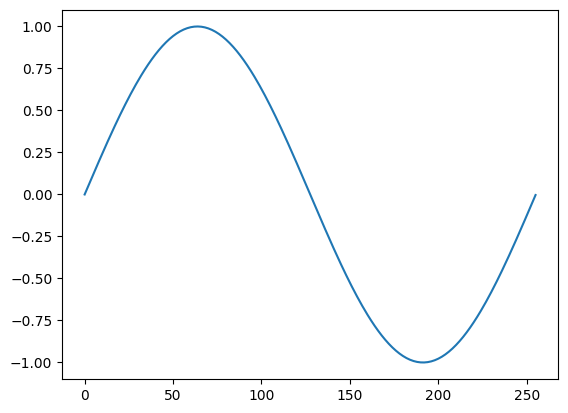

In [2]:
N = 256
s = np.sin(2*3.14*np.linspace(0, 1, num=N))
plt.plot(s)

На базе созданного массива определим генератор, возвращающий скользящее окно:  
- x - массив размером в заданную длину окна   
- y - следующее за массивом x значение

In [3]:
ws = 24    # window size

def data_gen():
    for i in range(N-ws):
        x = s[i:i+ws].reshape(-1,1)
        y = s[i+ws].reshape(1)
        yield x, y

In [4]:
dgen = data_gen()

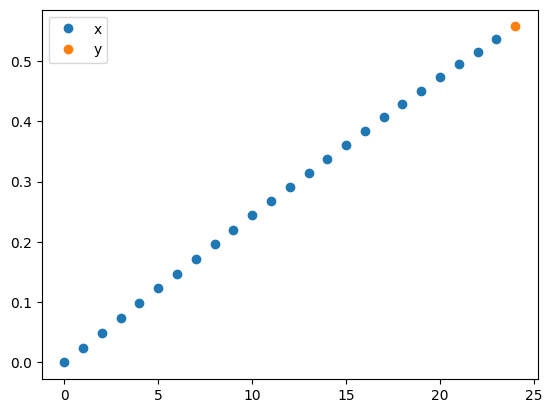

In [5]:
x, y = next(dgen)
plt.plot(range(ws), x, 'o')
plt.plot(ws, y, 'o')
plt.legend(['x', 'y'])

Создадим tf.Dataset на базе нашего генератора

In [6]:
x.shape, y.shape

((24, 1), (1,))

In [7]:
ds = tf.data.Dataset.from_generator(
    data_gen,     
    output_signature=(
        tf.TensorSpec(shape=(ws, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(1, ), dtype=tf.float32)),
).batch(1)

2022-10-14 16:14:29.700175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Создадим модель на базе простой RNN, предсказывающая всего одно число.

<img src=https://www.tensorflow.org/static/tutorials/structured_data/images/lstm_1_window.png>

In [8]:
model = K.Sequential([
        K.layers.InputLayer((ws, 1)),
        K.layers.SimpleRNN(16),
        K.layers.Dense(1)
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                288       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='mse')

history = model.fit(ds, epochs=10)

Epoch 1/10
232/232 [==============================] - 2s 7ms/step - loss: 2.0510e-04
Epoch 2/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0031
Epoch 3/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0426
Epoch 4/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0026
Epoch 5/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0068
Epoch 6/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0056
Epoch 7/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0065
Epoch 8/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0071
Epoch 9/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0153
Epoch 10/10
232/232 [==============================] - 1s 6ms/step - loss: 0.0060


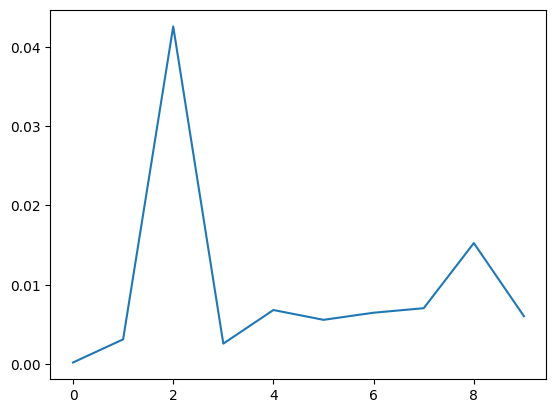

In [10]:
plt.plot(history.history['loss'])

In [11]:
y_ = model.predict(ds)

232/232 [==============================] - 1s 3ms/step


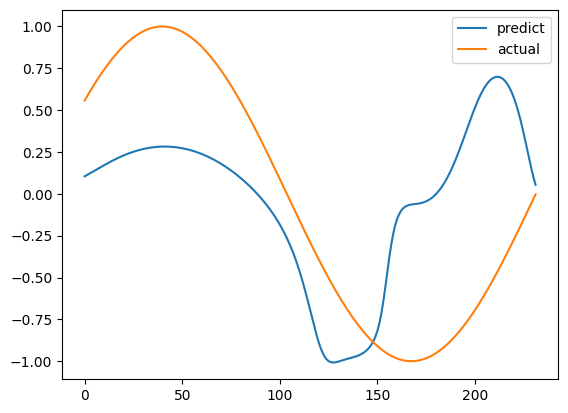

In [12]:
plt.plot(y_)
plt.plot(s[ws:])
plt.legend(['predict', 'actual'])

Протестируем на сигнале с другой частотой и шумом

In [13]:
s = np.sin(2*3.14*np.linspace(0, 5, num=N)) + np.random.randn(N)*0.1

test_ds = tf.data.Dataset.from_generator(
    data_gen,     
    output_signature=(
        tf.TensorSpec(shape=(ws, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(1, ), dtype=tf.float32)),
).batch(1)

In [14]:
y_ = model.predict(test_ds)

232/232 [==============================] - 1s 3ms/step


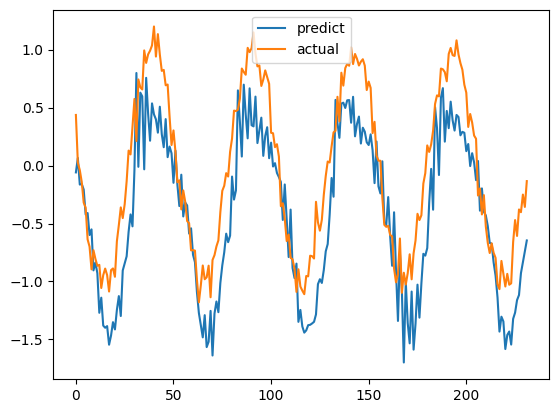

In [15]:
plt.plot(y_)
plt.plot(s[ws:])
plt.legend(['predict', 'actual'])

### Задание

Проведите эксперименты с различными гиперпараметрами (длина окна, размер скрытого слоя h), а также архитектурой LSTM.  

**Вопрос 1.** При какой гиперпараметрах получаются лучшие предсказания на train и test выборках?  

**Вопрос 2.** Будет ли архитектура LSTM лучше для таких синтетических данных?
